# Purpose:

This notebook will demonstrate how to generate key plots using the fitting results obtained with gsf.

As an example, here we use data points and fitting results from [Morishita+2020](https://ui.adsabs.harvard.edu/abs/2020arXiv201106051M/abstract).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.cosmology import WMAP9 as cosmo
from astropy.io import fits,ascii
import asdf

from gsf.function import flamtonu,fnutolam


## 1. SFH;

In [2]:
DIR_OUT = './output_ALMA/'
id = '24569'
file = '%sSFH_%s_PA00.fits'%(DIR_OUT, id)
fd_sfh = fits.open(file)[1].data

file_sum = '%ssummary_%s_PA00.fits'%(DIR_OUT, id)
hd_sum = fits.open(file_sum)[1].header
fd_sum = fits.open(file_sum)[1].data
#print(hd_sum)

time = fd_sfh['time']
sfr16 = fd_sfh['logSFR16']
sfr50 = fd_sfh['logSFR50']
sfr84 = fd_sfh['logSFR84']
#sfr16 = fd_sfh['SFR16']
#sfr50 = fd_sfh['SFR50']
#sfr84 = fd_sfh['SFR84']



Text(0, 0.5, 'SFR / Msun yr$^{-1}$')

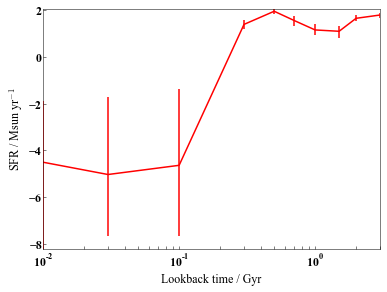

In [3]:
# Plot SFH;
plt.errorbar(time, sfr50, yerr=[sfr50-sfr16,sfr84-sfr50])

plt.xscale('log')
plt.xlabel('Lookback time / Gyr')
plt.ylabel('SFR / Msun yr$^{-1}$')


## 2. SED;

In [4]:
# Plot grism data?
f_grism = True

# Asdf file for the best fit spectrum;
file = '%sgsf_spec_%s.asdf'%(DIR_OUT, id)
fd_sed = asdf.open(file).tree
scl = fd_sed['scale']
wave_model = fd_sed['wave_model']
flux_model_50 = fd_sed['f_model_50']
flux_model_16 = fd_sed['f_model_16']
flux_model_84 = fd_sed['f_model_84']

# Each component for stellar
wave_model_stel = fd_sed['wave_model_stel']
for aa in range(len(time)):
    ftmp = fd_sed['f_model_stel_%d'%aa]
    if aa == 0:
        flux_model_stel = np.zeros((len(time),len(ftmp)))
    flux_model_stel[aa,:] = ftmp[:]
    
# Dust
wave_model_dust = fd_sed['wave_model_dust']
flux_model_dust = fd_sed['f_model_dust']

# Obs. photom data points;
wave_obs = fd_sed['wave_obs']
flux_obs = fd_sed['f_obs']
eflux_obs = fd_sed['e_obs']

wave_bb_model = fd_sed['wave']
flux_bb_50 = fd_sed['fnu_50']

# Obs. grism;
if f_grism:
    wg0 = fd_sed['wg0_obs']
    fg0 = fd_sed['fg0_obs']
    eg0 = fd_sed['eg0_obs']
    
    wg1 = fd_sed['wg1_obs']
    fg1 = fd_sed['fg1_obs']
    eg1 = fd_sed['eg1_obs']



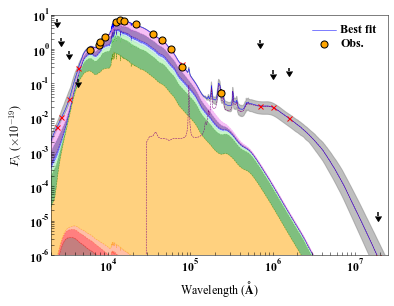

In [5]:
# Plot in F_nu or F_lambda?
col = ['violet', 'indigo', 'b', 'lightblue', 'lightgreen', 'g', 'orange', 'coral', 'r', 'darkred']#, 'k']

# Plot the best fit total;
plt.fill_between(wave_model, flux_model_16, flux_model_84, color='gray', linestyle='-', alpha=0.5, zorder=-1)
plt.plot(wave_model, flux_model_50, color='b', linestyle='-', zorder=0, label='Best fit', lw=0.5)

# Each component;
con_each = (wave_model_dust>0)
plt.plot(wave_model_dust[con_each], flux_model_dust[con_each], color='purple', linestyle='--', zorder=0, label='', lw=.5)

for aa in range(len(time)):
    jj = len(time) - aa - 1
    if aa == 0:
        ysum = np.zeros(len(flux_model_stel[0,:]),'float')
        ysum[:] += flux_model_stel[aa,:]
    else:
        ysum += flux_model_stel[aa,:]

    con_each = (wave_model_stel>0)
    plt.fill_between(wave_model_stel[con_each], ysum[con_each]-flux_model_stel[aa,:], ysum[con_each], linestyle='--', zorder=0, alpha=0.5, label='', lw=.5, color=col[jj])


# This needs to be converted in flam
con = (flux_obs / eflux_obs > 1)
con_nd = (~con)

# Flam
plt.scatter(wave_obs[con], flux_obs[con], c='orange', edgecolor='k', s=50, marker='o', zorder=2, label='Obs.')
plt.errorbar(wave_obs[con], flux_obs[con], yerr=eflux_obs[con], color='k', linestyle='', ms=5, marker='', zorder=1)

sigma = 1.0
leng = 0.2 * eflux_obs 
plt.errorbar(wave_obs[con_nd], eflux_obs[con_nd], yerr=leng[con_nd],\
             uplims=eflux_obs[con_nd], color='k', linestyle='', ms=5, marker='', zorder=1)

flux_bb_50_lam = fnutolam(wave_bb_model, flux_bb_50/scl)
plt.plot(wave_bb_model, flux_bb_50_lam, c='r', ms=5, marker='x', linestyle='', zorder=1, label='')

plt.ylim(1e-6, 1e1)
plt.ylabel('$F_\lambda$ ($\\times10^{-19}$)')

plt.xlim(2000, 25000000)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')

plt.xscale('log')
plt.yscale('log')

plt.legend(loc=1)

### Since wavelength coverage is pretty wide, make y-axis F_lambda * lambda

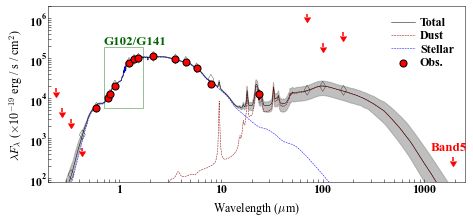

In [6]:
col = ['violet', 'indigo', 'b', 'lightblue', 'lightgreen', 'g', 'orange', 'coral', 'r', 'darkred']#, 'k']
Alim = 10
f_grsm = True

# Figure;
fig = plt.figure(figsize=(6.5,3.2*6.5/7))
fig.subplots_adjust(top=0.98, bottom=0.16, left=0.1, right=0.99, hspace=0.15, wspace=0.25)
ax1 = fig.add_subplot(111)

xsize = 0.29
ysize = 0.25

#
ax1.fill_between(wave_model, flux_model_16 * wave_model, flux_model_84 * wave_model, color='gray', linestyle='-', alpha=0.5, zorder=-1)
ax1.plot(wave_model, flux_model_50 * wave_model, color='k', linestyle='-', zorder=0, label='Total', lw=0.5)

# Each;
con_each = (wave_model_dust>0)
ax1.plot(wave_model_dust[con_each], wave_model_dust[con_each]*flux_model_dust[con_each], color='darkred', linestyle='--', zorder=0, label='Dust', lw=.5)

for aa in range(len(time)):
    jj = len(time) - aa - 1
    zo = 0 #jj
    if aa == 0:
        ysum = np.zeros(len(flux_model_stel[0,:]),'float')
        ysum[:] += flux_model_stel[jj,:]
    else:
        ysum += flux_model_stel[jj,:]
    con_each = (wave_model_stel>0)
    if fd_sum['A%d'%jj][1]>Alim:
        print(fd_sum['A%d'%jj][1], col[jj])
        plt.plot(wave_model_stel[con_each], ysum[con_each]*wave_model_stel[con_each], linestyle='--', label='', lw=.5, color=col[jj], zorder=zo)

ax1.plot(wave_model_stel[con_each], ysum[con_each]*wave_model_stel[con_each], linestyle='--', label='Stellar', lw=.5, color='b', zorder=zo)



con = (flux_obs / eflux_obs > 1)
con_nd = (~con)

# Flam
col_bb = 'red'
col_model = 'k'

ax1.scatter(wave_obs[con], flux_obs[con]*wave_obs[con], c=col_bb, edgecolor='k', s=50, marker='o', zorder=3, label='Obs.')
ax1.errorbar(wave_obs[con], flux_obs[con]*wave_obs[con], yerr=eflux_obs[con]*wave_obs[con], color='k', linestyle='', ms=5, marker='', zorder=1)

sigma = 1.0
leng = 0.2 * eflux_obs * wave_obs
ax1.errorbar(wave_obs[con_nd], eflux_obs[con_nd]*wave_obs[con_nd], yerr=leng[con_nd],\
             uplims=eflux_obs[con_nd]*wave_obs[con_nd], color=col_bb, linestyle='', ms=5, marker='', zorder=1)

if True:
    flux_bb_50_lam = fnutolam(wave_bb_model, flux_bb_50/scl)
    ax1.scatter(wave_bb_model[:], flux_bb_50_lam[:]*wave_bb_model[:], color='None', edgecolor=col_model, s=50,\
                marker='d', zorder=2, label='', lw=0.3)

ax1.set_ylim(8e1, 2e6)
ax1.set_ylabel('$\lambda F_\lambda$ ($\\times10^{-19}$ erg / s / cm$^2$)')

plt.xlim(2000, 25000000)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xticks([1e4, 1e5, 1e6, 1e7])
ax1.set_xticklabels(['1', '10', '100', '1000'])
plt.xlabel('Wavelength ($\\mu$m)')


# Rectabgle for grism window;
xmin = 7000
xmax = 17000
ymin = 8e-1
ymax = 1.1e1

# Box for grism region;
left, bottom, width, height = (xmin, ymin * xmin, xmax-xmin, ymax * xmax - ymin * xmin)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="none", edgecolor='darkgreen', alpha=0.4, zorder=-2)
ax1.add_patch(rect)
ax1.text(xmin, ymax * xmax * 1.2, 'G102/G141', color='darkgreen', fontsize=13)

# ALMA band 5 text;
ax1.text(11500000, 5e2, 'Band5', color='r', fontsize=13)

plt.legend(loc=1)
#plt.savefig('sed_%s.png'%(id), dpi=300)


## And zoom-in plot for grism spectra;

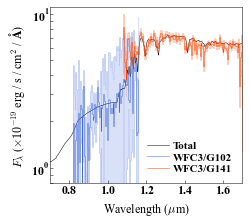

In [7]:
f_grsm = True

# Figure;
fig = plt.figure(figsize=(3.5*6.5/7,3.2*6.5/7))
fig.subplots_adjust(top=0.98, bottom=0.16, left=0.17, right=0.99, hspace=0.15, wspace=0.25)
ax1 = fig.add_subplot(111)

xsize = 0.29
ysize = 0.25
ax1.plot(wave_model, flux_model_50, color='k', linestyle='-', zorder=0, label='Total', lw=0.5)

# This needs to be converted in flam
plt.step(wg0, fg0, c='royalblue', ms=1, marker='', zorder=2, ls='-', label='WFC3/G102', lw=0.5)
plt.step(wg1, fg1, c='orangered', ms=1, marker='', zorder=2, ls='-', label='WFC3/G141', lw=0.5)

delwg0 = 0
delwg1 = 0
plt.fill_between(wg0+delwg0/2, fg0-eg0, fg0+eg0, color='royalblue', zorder=2, label='', step='pre', alpha=0.2)
plt.fill_between(wg1+delwg1/2, fg1-eg1, fg1+eg1, color='orangered', zorder=2, label='', step='pre', alpha=0.2)

ax1.set_ylim(ymin,ymax)
ax1.set_ylabel('$F_\lambda$ ($\\times10^{-19}$ erg / s / cm$^2$ / $\mathrm{\AA}$)')

plt.xlim(xmin,xmax)
#ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xticks([8000, 10000, 12000, 14000, 16000])
ax1.set_xticklabels(['0.8', '1.0', '1.2', '1.4', '1.6'])
plt.xlabel('Wavelength ($\\mu$m)')

plt.legend(loc=4, fontsize=11)
#plt.savefig('sed_grism_%s.png'%(id), dpi=350)
